In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Bước 3: Giải nén ảnh
import zipfile
import os

zip_path = '/content/drive/MyDrive/DATA/Tuna.v1i.coco.zip'  # hoặc thay bằng đường dẫn file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/drive/MyDrive/DATA/tuna_images')

In [ ]:
# Bước 4: Đọc file Excel
import pandas as pd

excel_path = '/content/drive/MyDrive/DATA/du_doan_ket_qua_hoa_hoc.xlsx'
df = pd.read_excel(excel_path)

# Xem các cột
df.head()

,dataset,image,bbox,mean_R,mean_G,mean_B,L*,a*,b*,MetMb,TBARS,HPO
0,train,IMG20220516121925_jpg.rf.ead9c7411dd6b2f3f05c0...,"[0, 0, 644, 605]",73.690437,58.913215,69.382136,26.726320,8.592859,-3.975158,1.594053,0.338934,0.092307
1,train,IMG20220516121741_jpg.rf.eb667b8799dd8173fd9de...,"[0, 0, 632, 636]",57.349527,49.073056,58.975967,21.573694,5.921345,-4.878242,1.563965,0.331240,0.089496
2,train,IMG20220516121536_jpg.rf.ebe269555bc3c4b481f03...,"[0, 0, 588, 687]",44.301419,32.896298,43.975156,14.433218,7.930275,-5.277038,1.529045,0.319923,0.088454
3,train,IMG20220516121057_jpg.rf.eac661c518a7224297d3d...,"[0, 0, 640, 640]",54.132219,33.332903,44.094575,15.885125,12.010773,-3.052928,1.537375,0.321316,0.089364
4,train,IMG20220515181623_jpg.rf.eb95400f83b89009a3517...,"[0, 0, 652, 632]",53.130533,28.853346,44.850989,14.514460,14.785010,-5.663392,1.536578,0.321194,0.088638


In [ ]:
# ----- PHẦN 1: CÀI ĐẶT THƯ VIỆN -----
!pip install -q pandas openpyxl scikit-learn tensorflow matplotlib joblib

# ----- PHẦN 2: NHẬP THƯ VIỆN -----
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Concatenate
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import joblib


In [ ]:
def rgb_to_lab_kaizoudou(rgb):
    # Input: rgb = [R, G, B], 0-255
    # 1. Chuẩn hóa về [0,1] theo màu quốc tế
    R, G, B = [v / 255.0 for v in rgb]

    # 2. Gamma correction / Hiệu chỉnh gamma cho độ sáng thực tế
    def gamma_correct(c):
        return ((c + 0.055)/1.055)**2.4 if c > 0.04045 else c / 12.92

    R_lin = gamma_correct(R)
    G_lin = gamma_correct(G)
    B_lin = gamma_correct(B)

    # 3. RGB → XYZ (D65) / chuyển RGB Liner sang XYZ
    X = R_lin * 0.4124 + G_lin * 0.3576 + B_lin * 0.1805
    Y = R_lin * 0.2126 + G_lin * 0.7152 + B_lin * 0.0722
    Z = R_lin * 0.0193 + G_lin * 0.1192 + B_lin * 0.9505

    # 4. Chuẩn hóa theo white point D65 (tham chiếu quốc tế)
    X /= 0.95047
    Y /= 1.00000
    Z /= 1.08883

    # 5. XYZ → L*a*b*
    def f(t):
        return t ** (1/3) if t > 0.008856 else (7.787 * t) + (16/116)

    fX = f(X)
    fY = f(Y)
    fZ = f(Z)

    L = (116 * fY) - 16
    a = 500 * (fX - fY)
    b = 200 * (fY - fZ)
    return [L, a, b]

def white_balance_grayworld(img):
    img = img.astype(np.float32) #chuyen kiểu ảnh sang float để tính toán
    mean_channels = img.mean(axis=(0,1)) #Tính trung bình từng kênh màu
    scale = mean_channels.mean() / (mean_channels + 1e-6) #Tính hệ số hiểu chỉnh cho từng kênh (sao cho các kênh màu gần nhau hơn(xám hóa))
    img *= scale #nhân hệ số các kênh
    img = np.clip(img, 0, 255)#cắt ở ngưỡng [0,255]
    return img.astype(np.uint8) #trả về uint8

def get_roi_bbox(img, bbox):# Cắt vùng ảnh
    x, y, w, h = map(int, bbox)
    return img[y:y+h, x:x+w]# Trả về ảnh trong bbox

def get_roi_pixels(img, mask_threshold=20):# Chọn các pixel “sáng” trong ROI để loại bỏ nền tối
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    mask = gray > mask_threshold #Chuyển ROI sang xám, chỉ lấy những pixel có cường độ lớn hơn mask_threshold.
    return img[mask]
#Lấy ngẫu nhiên tối đa n_samples pixel trong ROI để tính giá trị trung bình và độ lệch chuẩn RGB.
def random_rgb_samples(roi_pixels, n_samples=100):
    if len(roi_pixels) == 0:
        return [np.nan]*3, [np.nan]*3 #Nếu ROI trống, trả về NaN.
    idx = np.random.choice(len(roi_pixels), min(n_samples, len(roi_pixels)), replace=False)
    samples = roi_pixels[idx]
    return samples.mean(axis=0), samples.std(axis=0)

#Pipeline tổng hợp: Đọc ảnh, kiểm tra bbox, cắt ROI, cân bằng trắng, mask, trích xuất đặc trưng màu, chuyển sang L*a*b*.
def process_image_bbox_expert(image_path, bbox, n_samples=100, mask_threshold=20):
    # Debug: Kiểm tra ảnh và bbox
    if not os.path.exists(image_path):
        print("Ảnh không tồn tại:", image_path)
        return [np.nan]*3, [np.nan]*3, [np.nan]*3
    img = np.array(Image.open(image_path).convert("RGB"))
    x, y, w, h = map(int, bbox)
    # Kiểm tra kích thước bbox
    if w <= 0 or h <= 0 or y+h > img.shape[0] or x+w > img.shape[1]:
        print(f"BBox lỗi: {bbox} với ảnh {image_path}, shape ảnh {img.shape}")
        return [np.nan]*3, [np.nan]*3, [np.nan]*3
    roi = img[y:y+h, x:x+w]
    if roi.size == 0:
        print(f"ROI rỗng: {bbox} ảnh {image_path}")
        return [np.nan]*3, [np.nan]*3, [np.nan]*3
    roi = white_balance_grayworld(roi)
    roi_pixels = get_roi_pixels(roi, mask_threshold)
    if len(roi_pixels) == 0:
        print(f"ROI không có pixel hợp lệ (sau mask): {bbox} ảnh {image_path}")
        return [np.nan]*3, [np.nan]*3, [np.nan]*3
    rgb_mean, rgb_std = random_rgb_samples(roi_pixels, n_samples)
    lab = rgb_to_lab_kaizoudou(rgb_mean)
    return rgb_mean, rgb_std, lab


In [ ]:
def extract_all_features_bbox(df, n_samples=100, mask_threshold=20):
    rgb_means, rgb_stds, labs = [], [], []#Khởi tạo danh sách kết quả
    img_data, valid_indices = [], []

    for idx, row in df.iterrows():#Duyệt từng dòng (ảnh) trong DataFrame
        img_path = row['image_path']
        bbox = row.get('bbox', None)
        try:#Tiền xử lý ảnh & kiểm tra điều kiện
            img_pre = load_and_preprocess_image(img_path)
            # Nếu ảnh lỗi, fill NaN cho tất cả đặc trưng
            if np.all(img_pre == 0) or bbox is None or not isinstance(bbox, (list, tuple)) or len(bbox) != 4:
                rgb_mean = [np.nan, np.nan, np.nan]
                rgb_std = [np.nan, np.nan, np.nan]
                lab = [np.nan, np.nan, np.nan]
            else: #Xử lý và trích xuất đặc trưng
                rgb_mean, rgb_std, lab = process_image_bbox_expert(img_path, bbox, n_samples, mask_threshold)
                # Đảm bảo luôn trả về 3 giá trị
                if not (isinstance(rgb_mean, (list, np.ndarray)) and len(rgb_mean) == 3):
                    rgb_mean = [np.nan, np.nan, np.nan]
                if not (isinstance(rgb_std, (list, np.ndarray)) and len(rgb_std) == 3):
                    rgb_std = [np.nan, np.nan, np.nan]
                if not (isinstance(lab, (list, np.ndarray)) and len(lab) == 3):
                    lab = [np.nan, np.nan, np.nan]
                    #Lưu đặc trưng, ảnh, chỉ số dòng
            rgb_means.append(list(rgb_mean))
            rgb_stds.append(list(rgb_std))
            labs.append(list(lab))
            img_data.append(img_pre)
            valid_indices.append(idx)
        except Exception as e:
            # Nếu có lỗi gì vẫn fill NaN cho đủ shape
            rgb_means.append([np.nan, np.nan, np.nan])
            rgb_stds.append([np.nan, np.nan, np.nan])
            labs.append([np.nan, np.nan, np.nan])
            img_data.append(np.zeros((128,128,3)))
            valid_indices.append(idx)
#Tạo DataFrame kết quả với chỉ các dòng hợp lệ
    df_filtered = df.loc[valid_indices].copy()
    #Chuyển list thành numpy array để truy cập cột
    rgb_means = np.array(rgb_means)
    rgb_stds = np.array(rgb_stds)
    labs = np.array(labs)
    # Đảm bảo đúng shape
    if rgb_means.ndim == 1:
        rgb_means = np.stack(rgb_means)
    if rgb_stds.ndim == 1:
        rgb_stds = np.stack(rgb_stds)
    if labs.ndim == 1:
        labs = np.stack(labs)
#Tạo cột đặc trưng mới cho DataFrame
    df_filtered['mean_R'] = rgb_means[:,0]
    df_filtered['mean_G'] = rgb_means[:,1]
    df_filtered['mean_B'] = rgb_means[:,2]
    df_filtered['R_std'] = rgb_stds[:,0]
    df_filtered['G_std'] = rgb_stds[:,1]
    df_filtered['B_std'] = rgb_stds[:,2]
    df_filtered['L*'] = labs[:,0]
    df_filtered['a*'] = labs[:,1]
    df_filtered['b*'] = labs[:,2]
    df_filtered['image_data'] = img_data

    return df_filtered


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
#Chọn đặc trưng (features) và nhãn (labels)
features = ['mean_R', 'mean_G', 'mean_B', 'L*', 'a*', 'b*']  # chọn các feature bạn muốn
X = df[features].values
y = df[['MetMb', 'TBARS', 'HPO']].values
# Chia tập train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#RandomForestRegressor là một mô hình hồi quy dựa trên ensemble learning, kết hợp nhiều cây quyết định (decision tree) lại với nhau để giảm overfitting và tăng độ chính xác.
# Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("Random Forest MAE:", mean_absolute_error(y_test, y_pred_rf, multioutput='raw_values'))
#Ridge Regression là một dạng hồi quy tuyến tính (linear regression) nhưng thêm điều chuẩn L2 (regularization) để tránh overfitting khi có nhiều đặc trưng hoặc đặc trưng tương quan mạnh.
# Ridge Regression hỗ trợ cho multioutput
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)
print("Ridge MAE:", mean_absolute_error(y_test, y_pred_ridge, multioutput='raw_values'))
#SVR (Support Vector Regression) là biến thể hồi quy của SVM (Support Vector Machine).
# SVR (dùng riêng cho từng output)
for idx, label in enumerate(['MetMb', 'TBARS', 'HPO']):
    svr = SVR()
    svr.fit(X_train, y_train[:, idx])
    y_pred_svr = svr.predict(X_test)
    print(f"SVR MAE {label}:", mean_absolute_error(y_test[:, idx], y_pred_svr))


Random Forest MAE: [0.00065575 0.00021034 0.0001043 ]
Ridge MAE: [0.00019718 0.00028468 0.00018273]
SVR MAE MetMb: 0.029611327073755044
SVR MAE TBARS: 0.009775807656864128
SVR MAE HPO: 0.0022052573931492596


In [ ]:
#Chuyển về giá trị gốc để đánh giá sai số
y_pred_orig = scaler_y.inverse_transform(mlp.predict(X_test))
y_test_orig = scaler_y.inverse_transform(y_test)
print("MLP Test MAE trên giá trị gốc:", mean_absolute_error(y_test_orig, y_pred_orig))

y_pred_svr_orig = scaler_y.inverse_transform(y_pred)
print("SVR Test MAE trên giá trị gốc:", mean_absolute_error(y_test_orig, y_pred_svr_orig))


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
MLP Test MAE trên giá trị gốc: 0.03777774758981021
SVR Test MAE trên giá trị gốc: 0.0003093241810860978


In [ ]:
import pandas as pd
import numpy as np

data_path = "/content/drive/MyDrive/DATA/du_doan_ket_qua_hoa_hoc.xlsx"
df = pd.read_excel(data_path)

# Lấy đặc trưng màu và chỉ số hóa học từ file Excel
X_color = df[['mean_R','mean_G','mean_B','L*','a*','b*']].values
y = df[['MetMb','TBARS','HPO']].values

# Kiểm tra và loại bỏ dòng có NaN
valid_mask = (~np.isnan(X_color).any(axis=1)) & (~np.isnan(y).any(axis=1))

print("Tổng số mẫu ban đầu:", len(X_color))
print("Tổng số mẫu hợp lệ sau lọc NaN:", valid_mask.sum())

if valid_mask.sum() == 0:
    print(" Không còn dòng dữ liệu nào hợp lệ!")
    print(df[['mean_R','mean_G','mean_B','L*','a*','b*','MetMb','TBARS','HPO']].head(10))
    print("Tổng số NaN từng cột:", df[['mean_R','mean_G','mean_B','L*','a*','b*','MetMb','TBARS','HPO']].isnull().sum())
    raise ValueError("Không còn mẫu hợp lệ để train! Kiểm tra dữ liệu đầu vào.")

X_color = X_color[valid_mask]
y = y[valid_mask]

# CHUẨN HÓA VÀ CHIA TẬP
from sklearn.preprocessing import StandardScaler
scaler_x = StandardScaler().fit(X_color)
scaler_y = StandardScaler().fit(y)
X_color_scaled = scaler_x.transform(X_color)
y_scaled = scaler_y.transform(y)

from sklearn.model_selection import train_test_split
X_col_train, X_col_test, y_train, y_test = train_test_split(
    X_color_scaled, y_scaled, test_size=0.2, random_state=42
)

print("Số lượng mẫu train:", X_col_train.shape[0])
print("Số lượng mẫu test:", X_col_test.shape[0])


Tổng số mẫu ban đầu: 1514
Tổng số mẫu hợp lệ sau lọc NaN: 1514
Số lượng mẫu train: 1211
Số lượng mẫu test: 303


In [ ]:
# ----- PHẦN 6: XÂY DỰNG MÔ HÌNH CNN + MLP -----
img_input = Input(shape=(224,224,3), name='img_input')
x = Conv2D(32, (3,3), activation='relu')(img_input)
x = MaxPooling2D((2,2))(x)
x = Conv2D(64, (3,3), activation='relu')(x)
x = MaxPooling2D((2,2))(x)
x = Flatten()(x)

color_input = Input(shape=(6,), name='color_input')
y_ = Dense(32, activation='relu')(color_input)

combined = Concatenate()([x, y_])
z = Dense(64, activation='relu')(combined)
z = Dropout(0.3)(z)
z = Dense(3)(z)

model = Model(inputs=[img_input, color_input], outputs=z)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])


In [ ]:
# ----- PHẦN 7: HUẤN LUYỆN -----
history = model.fit([X_img_train, X_col_train], y_train,
                    validation_data=([X_img_test, X_col_test], y_test),
                    epochs=100, batch_size=32)



Epoch 1/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - loss: 0.0316 - mae: 0.1251 - val_loss: 0.0029 - val_mae: 0.0390
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - loss: 0.0324 - mae: 0.1245 - val_loss: 0.0024 - val_mae: 0.0391
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - loss: 0.0351 - mae: 0.1293 - val_loss: 0.0030 - val_mae: 0.0427
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - loss: 0.0347 - mae: 0.1294 - val_loss: 0.0022 - val_mae: 0.0353
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - loss: 0.0330 - mae: 0.1235 - val_loss: 0.0029 - val_mae: 0.0415
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - loss: 0.0310 - mae: 0.1210 - val_loss: 0.0026 - val_mae: 0.0392
Epoch 7/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - loss: 0.0316 - mae: 0.1256 - val_loss: 0.0023 - val_mae: 0.0349
Epoch 8/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - loss: 0.0304 - mae: 0.1210 - val_loss: 0.0026 - val_mae: 0.0407
Epoch 9/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - loss: 0.032

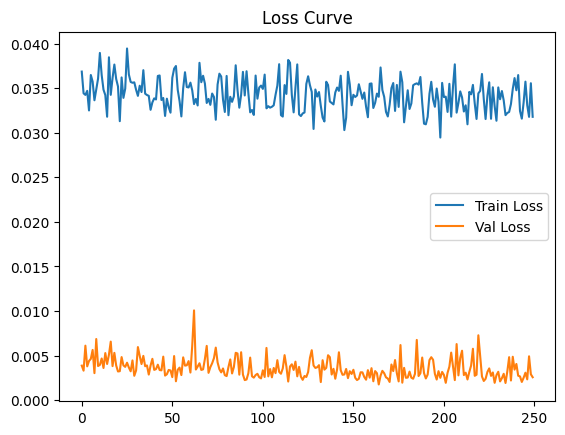

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 172ms/step - loss: 0.0029 - mae: 0.0368
Test Loss: 0.0026 | Test MAE: 0.0360


In [ ]:
# 7. Đánh giá mô hình
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()

loss, mae = model.evaluate([X_img_test, X_col_test], y_test)
print(f"Test Loss: {loss:.4f} | Test MAE: {mae:.4f}")

In [ ]:
# ----- PHẦN 8: LƯU MÔ HÌNH VÀ SCALER -----
model.save("/content/drive/MyDrive/DATA/multi_input_model.h5")
joblib.dump(scaler_x, "/content/drive/MyDrive/DATA/scaler_x.save")
joblib.dump(scaler_y, "/content/drive/MyDrive/DATA/scaler_y.save")


['/content/drive/MyDrive/DATA/scaler_y.save']